# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

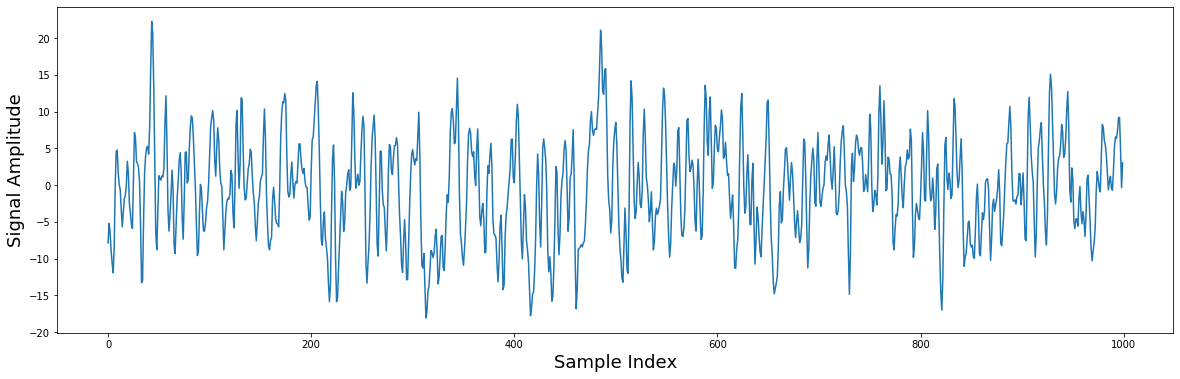

In [1]:
import numpy as np;   import matplotlib.pyplot as plt
%matplotlib inline

# extract spike waveforms
def get_spikes(data, winSize=80, thresScale=5, offset=10, thresMax=350):
    thres=np.mean(np.abs(data)) * thresScale              # define threshold based on data mean
    pos=np.where( data > thres )[0]                       # identify where the threshold is crossed
    pos=pos[pos > winSize]                                # limit "pos" to size of spike window
    spikes=[]                                             # prepare storage for location of spikes
    waveform=np.empty([1, winSize*2])                     # prepare storage for spikes
    
    for i in pos:                                         # extract potential spikes, then align peaks
        if i < data.shape[0] - (winSize+1):               # - if waveform exceeds the threshold...
            waveCand=data[ i : i+winSize*2 ]              # --- extract waveform candidate
            if np.max(waveCand) < thresMax:               # --- if the window below the upper threshold...
                sampNow=np.argmax(waveCand) + i           # ------ sample with maximum data point in window
                waveCand=data[sampNow-winSize+offset : \
                              sampNow+winSize+offset]     # ------ peak-center waveform
                spikes=np.append(spikes, sampNow)         # ------ append current wave indices to list of spikes
                waveform=np.append(waveform, \
                                   waveCand.reshape(1, winSize*2), axis=0) # append waveform to coll. of spikes
    ind=np.where( np.diff(spikes) > 1 )[0]                # remove duplicates
    spkID=spikes[ind];     waves=waveform[ind]            # preserve non-replicated outputs
    return spkID,waves

trace=np.load('../Datasets/spike_sort/simulation_1.npy')  # load dataset

fig=plt.figure(figsize=(20,6));  plt.plot( trace[:1000] ) # display parts of the raw waveform data
plt.xlabel('Sample Index', fontsize=18); plt.ylabel('Signal Amplitude',fontsize=18)
plt.show()

With the dataset loaded, we will now extract action potential spikes from our raw patch clamp readings.

Series A / threshold = 15  complete! ( 0.2 s )
Series B / threshold = 10  complete! ( 0.8 s )
Series C / threshold = 7  complete! ( 2.2 s )
Series D / threshold = 6  complete! ( 4.4 s )
Series E / threshold = 5  complete! ( 12.9 s )
Series F / threshold = 4  complete! ( 41.8 s )
Spike detection complete! ( 62.0 s elapsed )


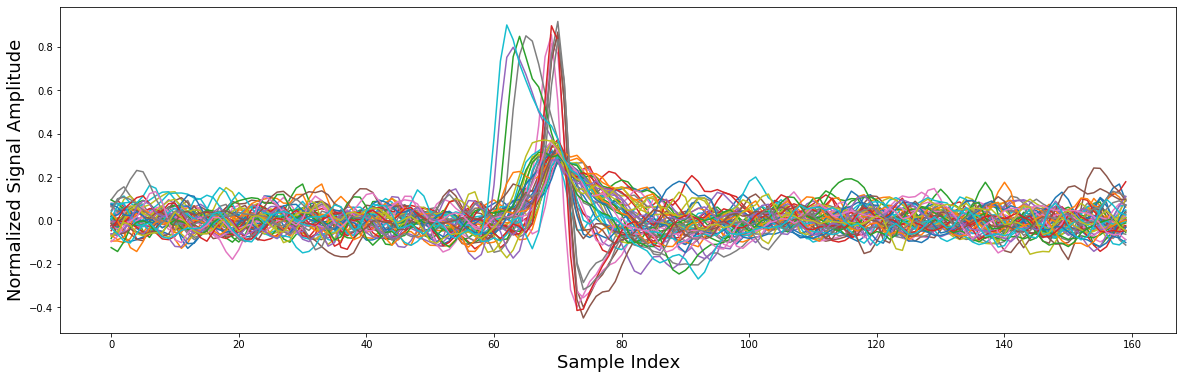

In [2]:
import time

dictScal={'A':15, 'B':10, 'C':7,  'D':6,  'E':5,  'F':4 }
dictTplt={'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]} # set template for dictionaries
dictSpk= {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]}
zipScale=zip( dictScal.keys(), dictScal.values(), range(len(dictScal)))

tAll=time.time()
for key, scale, n in zipScale:
    tIter=time.time()                                   # start timing current loop
    spkID,spikeNow=get_spikes( trace, thresScale=scale, winSize=80, offset=10, thresMax=350 )
    spikeNow=spikeNow / np.max(abs(spikeNow))           # peak-normalize the identified spikes
    dictSpk[key]=spikeNow                               # store spikes in dictionary
    tIter=time.time()-tIter                             # calculate time elapsed
    print('Series',key,'/ threshold =',scale,\
          ' complete! (',round(tIter,1),'s )')
    
tAll=time.time()-tAll                                   # calculate time elapsed for entire loop to run
print('Spike detection complete! (', round(tAll,0),'s elapsed )')

fig=plt.figure(figsize=(20,6))                          # display example of isolated spikes
plt.plot( dictSpk['D'][:50].T )
plt.xlabel('Sample Index', fontsize=18); plt.ylabel('Normalized Signal Amplitude',fontsize=18)
plt.show()

In the interest of rigor, dimensionality reduction will also be conducted via locally-linear embedding and isomaps, as well as through PCA.

In [3]:
from sklearn.decomposition  import PCA
from sklearn.manifold       import LocallyLinearEmbedding, Isomap

seed=16000
Ncomp=5

dictPCA={'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]}
dictLLE={'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]}
dictIso={'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[]}

tAll=time.time()
for key, spikeMtx, n in zip( dictSpk.keys(), dictSpk.values(), range(len(dictSpk)) ):
    
    spikesNow=spikeMtx
    
    mani1=PCA( n_components=Ncomp, random_state=seed )
    mani2=LocallyLinearEmbedding( n_components=Ncomp, random_state=seed )
    mani3=Isomap( n_components=Ncomp )
    
    resultPCA=mani1.fit_transform(spikesNow)
    resultLLE=mani2.fit_transform(spikesNow)
    resultIso=mani3.fit_transform(spikesNow)
    
    dictPCA[key]=[resultPCA[:,0], resultPCA[:,1]]
    dictLLE[key]=[resultLLE[:,0], resultLLE[:,1]]
    dictIso[key]=[resultIso[:,0], resultIso[:,1]]
    
    print('Series',key,'complete!')

tAll=time.time()-tAll
print('Dim. reduction complete! (', round(tAll,0),'s elapsed )')

Series A complete!
Series B complete!
Series C complete!
Series D complete!
Series E complete!
Series F complete!
Dim. reduction complete! ( 16.0 s elapsed )


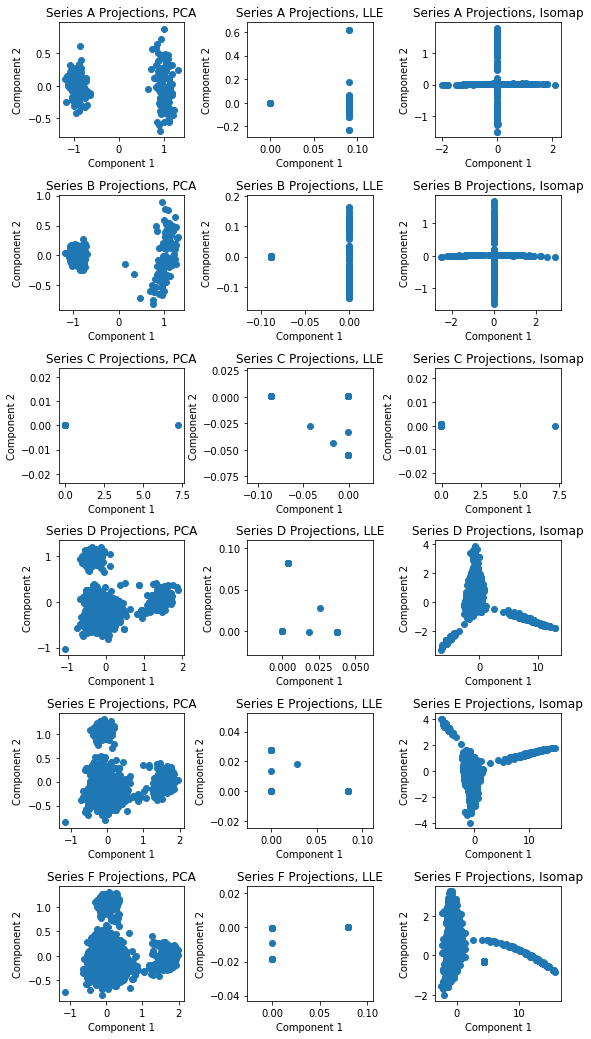

In [4]:
fig=plt.figure(figsize=( 9,3*len(dictSpk) ))

for key, n in zip( dictSpk.keys(), range(len(dictSpk))):
    
    titleA=' '.join(['Series',key,'Projections, PCA'])
    titleB=' '.join(['Series',key,'Projections, LLE'])
    titleC=' '.join(['Series',key,'Projections, Isomap'])
    
    plt.subplot( len(dictSpk), 3, 1+3*n )
    plt.scatter( dictPCA[key][0], dictPCA[key][1] )
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title( titleA )
    
    plt.subplot( len(dictSpk), 3, 2+3*n )
    plt.scatter( dictLLE[key][0], dictLLE[key][1] )
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title( titleB )
    
    plt.subplot( len(dictSpk), 3, 3+3*n )
    plt.scatter( dictIso[key][0], dictIso[key][1] )
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title( titleC )
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

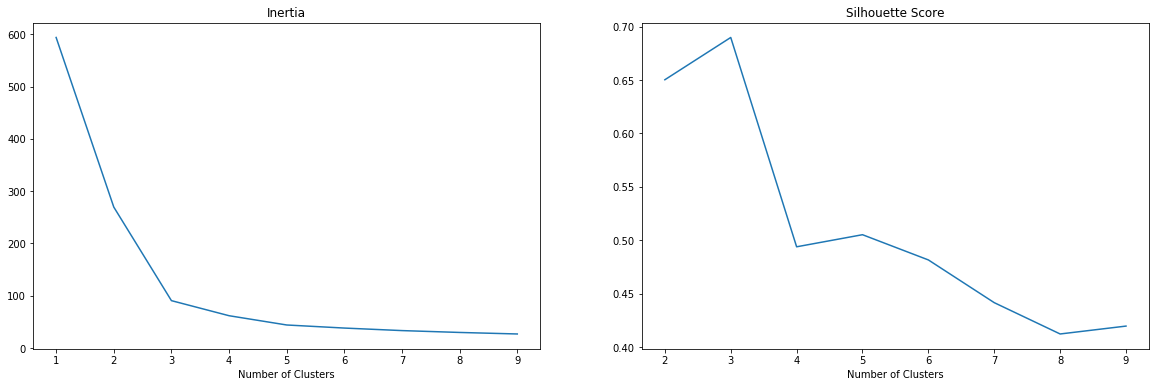

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seed=0          # RNG seed for k-means
maxGroups=10    # max number of clusters

# define 'series' for further analysis
seriesWant='D'
A=dictPCA[seriesWant][0].reshape(-1, 1); B=dictPCA[seriesWant][1].reshape(-1, 1)
X=np.concatenate( (A,B), axis=1 )

KperN=[KMeans(n_clusters=N, random_state=seed).fit(X) for N in range(1,maxGroups)]

iner=[model.inertia_ for model in KperN]                         # inertia for each k-means
silh=[silhouette_score(X, model.labels_) for model in KperN[1:]] # silhouette score for each k-means
asgn=[model.labels_ for model in KperN[1:]]

fig=plt.figure(figsize=(20,6))

plt.subplot(121); plt.plot( range(1,maxGroups), iner )
plt.xlabel('Number of Clusters'); plt.title( 'Inertia' )

plt.subplot(122); plt.plot( range(2,maxGroups), silh )
plt.xlabel('Number of Clusters'); plt.title( 'Silhouette Score' )

plt.show()

Text(0.5, 1.0, 'Isolated Neuron Action Potentials')

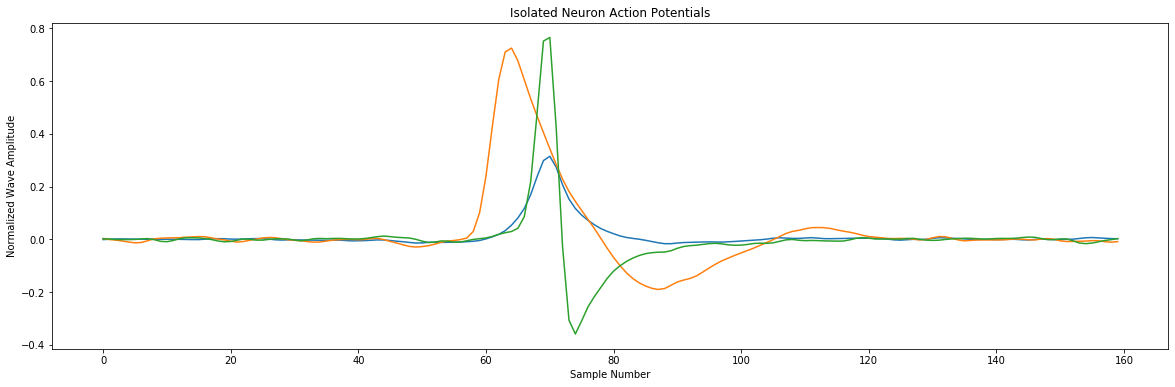

In [6]:
numNeurons=3  # use above diagrams to identify most probable number of neurons

fig=plt.figure(figsize=(20,6))  # initialize figure
spikeNow=dictSpk[seriesWant]    # get spikes for series chosen in previous cell
avg1=spikeNow[ asgn[numNeurons-2]==0,: ].mean(axis=0);  plt.plot(avg1, zorder=1)
avg2=spikeNow[ asgn[numNeurons-2]==1,: ].mean(axis=0);  plt.plot(avg2, zorder=2)
avg3=spikeNow[ asgn[numNeurons-2]==2,: ].mean(axis=0);  plt.plot(avg3, zorder=3)

plt.xlabel('Sample Number'); plt.ylabel('Normalized Wave Amplitude')
plt.title( 'Isolated Neuron Action Potentials' )